### 라이브러리를 import 합니다.

In [19]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 각각의 이미지를 불러오고, 시각화합니다.

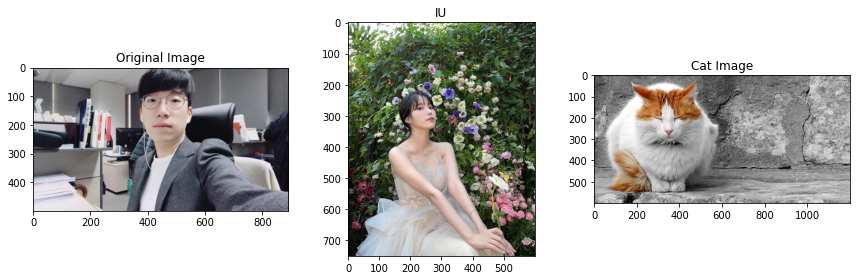

In [2]:
# 이미지 경로
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
iu_path = os.getenv('HOME')+'/aiffel/exploration 10/아이유.jpg'
cat_path = os.getenv('HOME')+'/aiffel/exploration 10/catcatcat.png'

# 이미지 읽기
img_orig = cv2.imread(img_path) 
iu_orig = cv2.imread(iu_path) 
cat_orig = cv2.imread(cat_path) 

# 이미지 시각화
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(132)
plt.imshow(cv2.cvtColor(iu_orig, cv2.COLOR_BGR2RGB))
plt.title('IU')

plt.subplot(133)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.title('Cat Image')

plt.tight_layout()
plt.show()

### Segmentation 모델을 불러옵니다.

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f169cf90160>)

In [4]:
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

### 추출된 value와 결과 이미지를 객체에 담습니다.

In [5]:
segvalues1, output1 = model.segmentAsPascalvoc(img_path)
segvalues2, output2 = model.segmentAsPascalvoc(iu_path)
segvalues3, output3 = model.segmentAsPascalvoc(cat_path)

### Segmentation 결과를 시각화합니다.

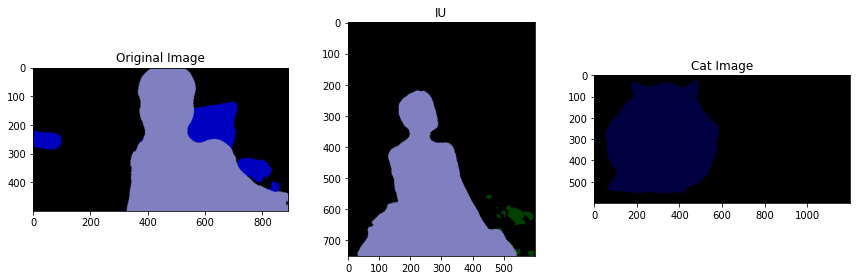

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(output1)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(output2)
plt.title('IU')

plt.subplot(133)
plt.imshow(output3)
plt.title('Cat Image')

plt.tight_layout()
plt.show()

### 각 이미지의 레이블을 확인하고 전처리합니다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [8]:
for class_id in segvalues1['class_ids']:
    print("original: ", LABEL_NAMES[class_id])
    
for class_id in segvalues2['class_ids']:
    print("아이유: ", LABEL_NAMES[class_id])
    
for class_id in segvalues3['class_ids']:
    print("고양이: ", LABEL_NAMES[class_id])

original:  background
original:  chair
original:  person
아이유:  background
아이유:  person
아이유:  pottedplant
고양이:  background
고양이:  cat


In [9]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print("original: ", colormap[15])
print("IU: ", colormap[15])
print("cat: ", colormap[8])

# 배열 순서 변경
original_colormap = np.array(colormap[15])[::-1]
iu_colormap = np.array(colormap[15])[::-1]
cat_colormap = np.array(colormap[8])[::-1]

original:  [192 128 128]
IU:  [192 128 128]
cat:  [64  0  0]


### Segmentation 함수

In [25]:
def segmentation(input_image, output_image, colormap):
    # 마스크 이미지와 레이블(color map)이 동일 영역 추출(bool)
    seg_map = np.all(output_image==colormap, axis=-1) 
    # image copy
    img_show = input_image.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    img_orig_blur = cv2.blur(input_image, (30,30))
    
    # Grayscale to BGR
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    # 반전 연산
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    # 블러 처리
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    # 이미지 합성
    img_concat = np.where(img_mask_color==255, input_image, img_bg_blur)
    
    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB), img_mask_color

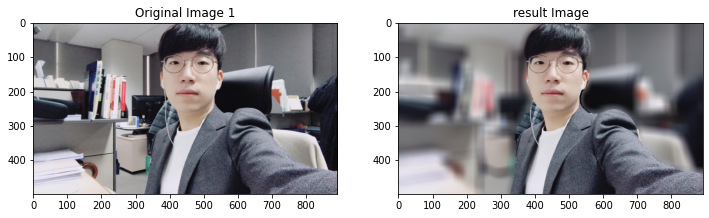

In [26]:
plt.figure(figsize=(12, 8))

# Original Image 1
result1,img_mask_color1 = segmentation(img_orig, output1, original_colormap)
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

# result
plt.subplot(122)
plt.imshow(result1)
plt.title('result Image')

plt.show()

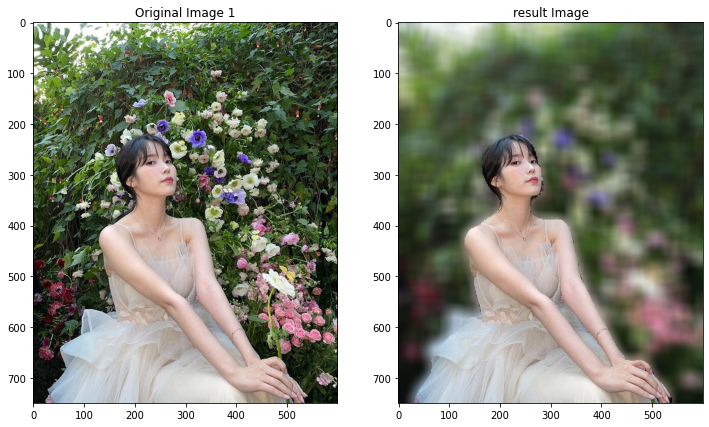

In [27]:
plt.figure(figsize=(12, 8))

# Original Image 2
result2,img_mask_color2 = segmentation(iu_orig, output2, iu_colormap)
plt.subplot(121)
plt.imshow(cv2.cvtColor(iu_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

# result
plt.subplot(122)
plt.imshow(result2)
plt.title('result Image')

plt.show()

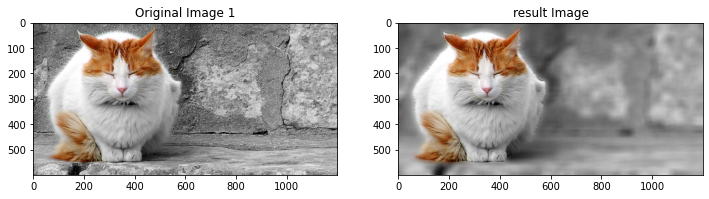

In [28]:
plt.figure(figsize=(12, 8))

# Original Image 3
result3,img_mask_color3 = segmentation(cat_orig, output3, cat_colormap)
plt.subplot(121)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

# result
plt.subplot(122)
plt.imshow(result3)
plt.title('result Image')

plt.show()

(1000, 1500, 3)


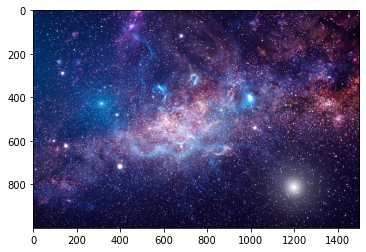

In [29]:
background_path = os.getenv('HOME')+'/aiffel/exploration 10/space.jpg'  
background_orig = cv2.imread(background_path) 

print(background_orig.shape)
plt.imshow(cv2.cvtColor(background_orig, cv2.COLOR_BGR2RGB))
plt.show()

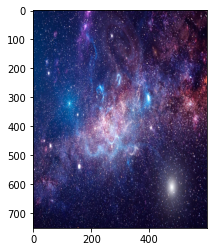

In [30]:
background_resize = cv2.resize(background_orig,(iu_orig.shape[1], iu_orig.shape[0]))
plt.imshow(cv2.cvtColor(background_resize , cv2.COLOR_BGR2RGB))
plt.show()

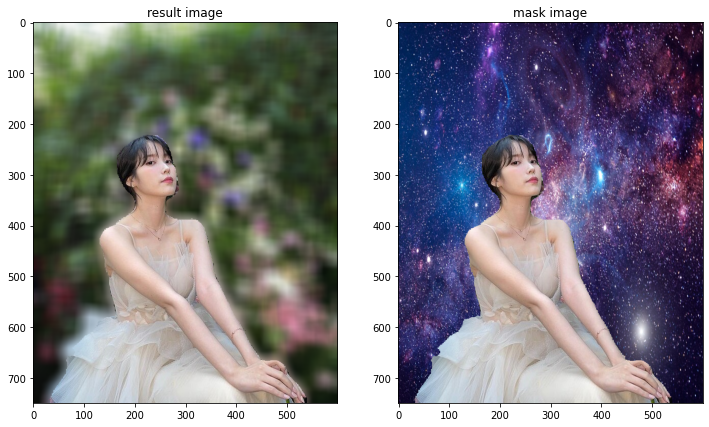

In [31]:
plt.figure(figsize=(12, 8))
result,img_mask_color = segmentation(iu_orig, output2, iu_colormap)

plt.subplot(121)
plt.imshow(result)
plt.title('result image')

plt.subplot(122) 
plt.imshow(cv2.cvtColor(np.where(img_mask_color==255, iu_orig, background_resize), cv2.COLOR_BGR2RGB))
plt.title('mask image')

plt.show()

### 인물모드 문제점 제시
- 후광 현상(halo effect) 발생
- 머리 묶은 영역이 삭제됨
- 얼굴(볼) 쪽에 빈 공간이 생겨 배경이 보임
- 손가락(손톱)이 짤림

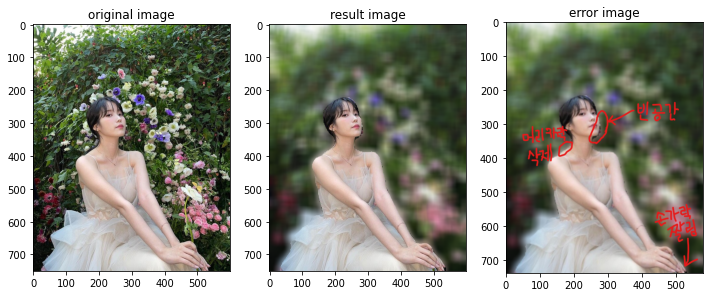

In [42]:
error = cv2.cvtColor(cv2.imread(os.getenv('HOME')+'/aiffel/exploration 10/result.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.subplot(131) 
plt.imshow(cv2.cvtColor(iu_orig, cv2.COLOR_BGR2RGB))
plt.title('original image')

plt.subplot(132)
plt.imshow(result)
plt.title('result image')

plt.subplot(133) 
plt.imshow(error)
plt.title('error image')

plt.show()

### 해결방안 제시
- 커널 사이즈 조절
- 마스크 팽창
    - 이진 마스크를 팽창시켜 세분화된 영역을 확장하여 작은 간격을 매우고 더 많은 세부 정보를 보전하도록 한다.
- 인페인팅(inpainting)
    - 인페인팅(복원 기술) 기술을 사용하여 이미지에서 누락된 영역을 채운다.
- 블렌딩 비율을 조절한다.

누락된 정보를 세부적으로 보존하기 위해서는 다양한 매겨변수의 실험을 해야한다.

In [62]:
def solution_segmentation(input_image, output_image, colormap):
    # 마스크 이미지와 레이블(color map)이 동일 영역 추출(bool)
    seg_map = np.all(output_image == colormap, axis=-1)
    
    # image copy
    img_show = input_image.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 팽창 연산
    kernel = np.ones((5, 5), np.uint8)
    img_mask = cv2.dilate(img_mask, kernel, iterations=1)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.8과 0.2는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.8, color_mask, 0.2, 0.0)

    # 블러 처리 (가우시안 블러)
    img_orig_blur = cv2.GaussianBlur(input_image, (25, 25), 0)

    # Grayscale to BGR
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 반전 연산
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # 이미지 합성
    img_concat = np.where(img_mask_color == 255, input_image, img_orig_blur)

    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB), img_mask_color

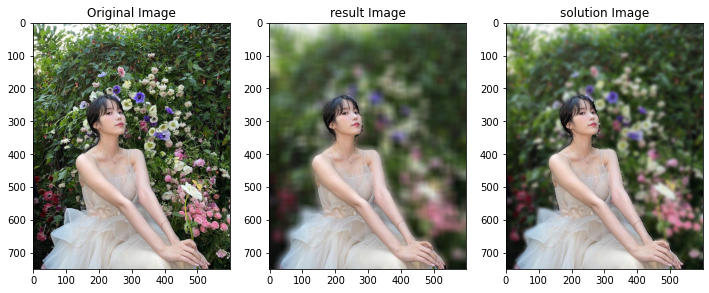

In [63]:
plt.figure(figsize=(12, 8))

# Original Image 2
solution_result, solution_img_mask_color = solution_segmentation(iu_orig, output2, iu_colormap)
plt.subplot(131)
plt.imshow(cv2.cvtColor(iu_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# result
plt.subplot(132)
plt.imshow(result)
plt.title('result Image')

# solution result
plt.subplot(133)
plt.imshow(solution_result)
plt.title('solution Image')

plt.show()

### 회고
Segmentaion을 해봤는데 NLP와 같이 텍스트를 다루는 것보다는 이미지를 다루는 것이 확실히 재밌는 것 같다. 세그멘테이션 하면서 생긴 문제를 생각해볼 수 있었고, 이를 해결하려고 생각해봤던 것도 좋았다. 